# Physical Activity Index

Calculating the activity index feature on each 24hr day (noon-noon). Based on index described in: 

`J. Bai,et al., “An Activity Index for Raw Accelerometer Data and Its Comparison with Other Activity Metrics,” PLoS ONE, vol. 11, 2016.`

In [10]:
import os
import sys
import getpass
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

import pyedflib
from pandas.compat import StringIO

In [11]:
user = getpass.getuser()
data_path = '/Users/{}/GitHub/fydp-data-science/data/ondri_data/'.format(user)

## Setting variables

In [12]:
channels = ['x','y','z']
intensity_levels = {
    'low' : [0,50],
    'moderate': [50,75],
    'high': [75,100]
}

## Methods to calculate index

#### Calculating the activity index using *Bai et al.*
- input data contains the rows contained in the current epoch

In [13]:
def calculate_activity_index(data ,channels):
    
    # calc index based on the equation found
    activity_index = np.var(data[channels], axis=0).mean() ** 0.5
    
    return activity_index

#### Rolling through data using 5sec epochs
- data is a day worth of data (noon-to-noon dumps)

In [14]:
def activity_index(data, data_path, sampling_rate, channels):
    
    results = pd.DataFrame(columns=['time','activity_index'])
    
    # find the number of points that make up the 5 sec epoch
    epoch = 5*sampling_rate
    shift = sampling_rate
    
    idx = 0
    while idx < data.shape[0] - epoch:
        
        # clip the epoch
        clip = data[channels].iloc[idx:idx+epoch]
        start_time = data.time[idx]
        
        # calculate the activity index for the clip
        activity_index = calculate_activity_index(clip ,channels)
        
        results.loc[idx] = [start_time, activity_index]
        
        idx = idx + shift
            
    return results

#### Finding and updating the maximum activity index
- input data format: `| time | activity_index |`
- maximum_activity format: `| date | activity_index |`

In [15]:
def get_maximum_activity(data, data_path):
    
    # check if a max intensity file exists
    if os.path.exists(data_path + 'maximum_activity.csv'):
        # grab the most recent maximum
        results = pd.read_csv(data_path + 'maximum_activity.csv', index_col=0)
        maximum_activity = results.activity_index[results.shape[0]-1]
    else:
        # setting up to calculate the first max -- this would be the first time code is run
        maximum_activity = 0
        results = pd.DataFrame(columns=['date','activity_index'])
    
    # calculate the current data sets max
    current_max = data.activity_index.max()
    
    if current_max > maximum_activity:
        results.loc[results.shape[0]] = [date.today(), current_max]
        
        # save new max activity
        results.to_csv(data_path + 'maximum_activity.csv')
    
    return results

#### Calculating the activity intensity level
- input data format: `| time | activity_index |`

In [27]:
def calculate_activity_intensity(data, data_path, maximum_activity, intensity_levels):
    
    results = pd.DataFrame(columns=['time','activity_index','intensity','level'])
        
    for idx,row in data.iterrows():
        # calculate intensity
        intensity = (row.activity_index / maximum_activity)*100
        
        # label the intensity 
        for key in intensity_levels.keys():
            if (intensity >= intensity_levels[key][0]) and (intensity <= intensity_levels[key][1]):
                level = key
         
        # add to df
        results.loc[idx] = [data.time[idx], data.activity_index[idx], intensity, level]
        
    return results

#### Visualizing how the different intensities map out on physical activity indices

In [38]:
def visualize_intensity_levels(data, maximum_activity):
    
    # set up figure
    plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Visualization of intensity levels')
    plt.xlabel('time')
    plt.ylabel('activity index')
    
    # plot the intensity bounds
    low, moderate, high = maximum_activity*0.5, maximum_activity*0.75, maximum_activity
    
    plt.fill_between(data.time, 0, low, color='#56C1FF', alpha=0.5, label='low intensity')
    plt.fill_between(data.time, low, moderate, color='#88FA4E', alpha=0.5, label='moderate intensity')
    plt.fill_between(data.time, moderate, high, color='#FFFC66', alpha=0.5, label='high intensity')
           
    # plot activity indexes
    plt.plot(data.time, data.activity_index, color='#5E5E5E', label='activity index')
    
    #plt.legend()

## Pulling in data

In [18]:
acc_data = pd.read_csv(data_path + 'acc_data.csv', index_col=0).reset_index().rename(columns={'index':'time'})
acc_data.head()

/Users/sunnywillert/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,time,x,y,z
0,0,-0.050722,-0.041538,-1.015312
1,1,-0.062537,-0.045464,-1.007386
2,2,-0.062537,-0.041538,-1.007386
3,3,-0.046783,-0.049391,-0.999459
4,4,-0.046783,-0.053318,-1.007386


In [19]:
# clip the specific set of data
data = acc_data[200000:1200000].reset_index().drop('index',1)

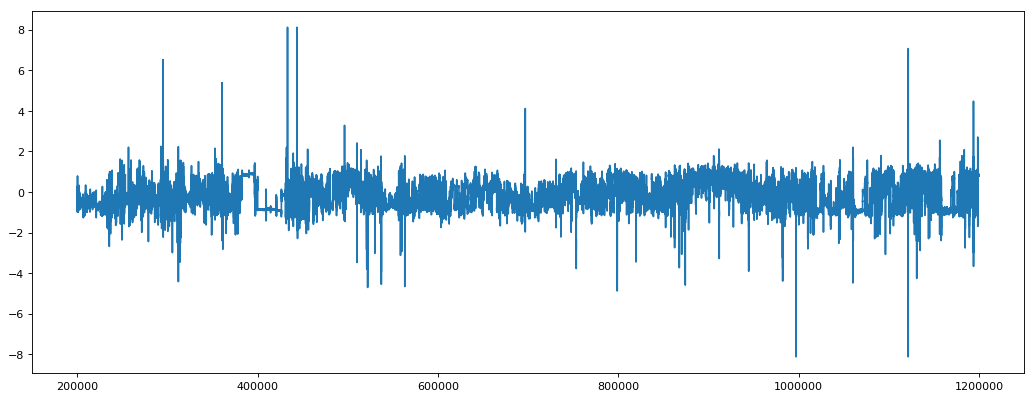

In [20]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data.time, data.z)

In [21]:
sampling_rate = 1000

## Running code

In [22]:
# calculate the activity indices
activity_indices = activity_index(data, data_path, sampling_rate, channels)
activity_indices.head()

,time,activity_index
0,200000.0,0.153284
1000,201000.0,0.104305
2000,202000.0,0.206031
3000,203000.0,0.256736
4000,204000.0,0.279575


Text(0, 0.5, 'activity index')

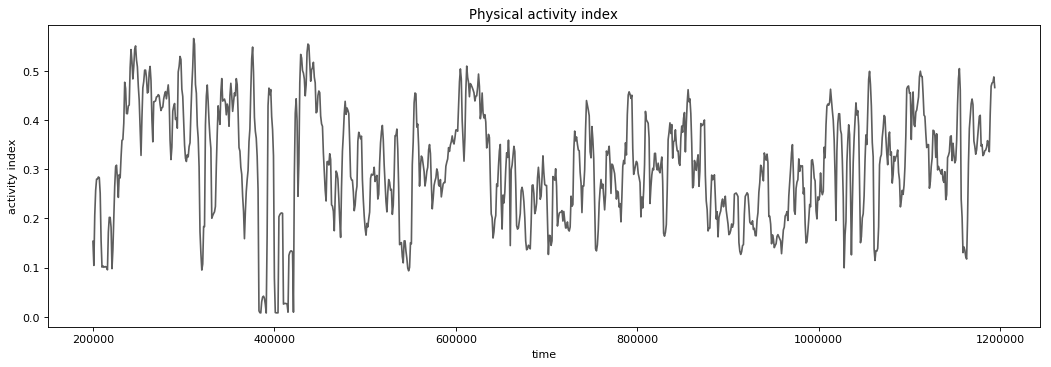

In [23]:
# plot to look at the activity index results
plt.figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(activity_indices.time, activity_indices.activity_index, color='#5E5E5E')
plt.title('Physical activity index')
plt.xlabel('time')
plt.ylabel('activity index')

In [24]:
# find the maximum activity index
maximum_activity = get_maximum_activity(activity_indices, data_path)
maximum_activity

,date,activity_index
0,2020-04-11,0.645486
1,2020-04-11,0.665996
2,2020-04-11,0.755801


In [28]:
# finding the activity index 
intensity = calculate_activity_intensity(activity_indices, data_path, maximum_activity.activity_index[maximum_activity.shape[0]-1], intensity_levels)
intensity.to_csv(data_path + 'activity_index.csv')
intensity.head()

,time,activity_index,intensity,level
0,200000.0,0.153284,20.280978,low
1000,201000.0,0.104305,13.800588,low
2000,202000.0,0.206031,27.259945,low
3000,203000.0,0.256736,33.968727,low
4000,204000.0,0.279575,36.990537,low


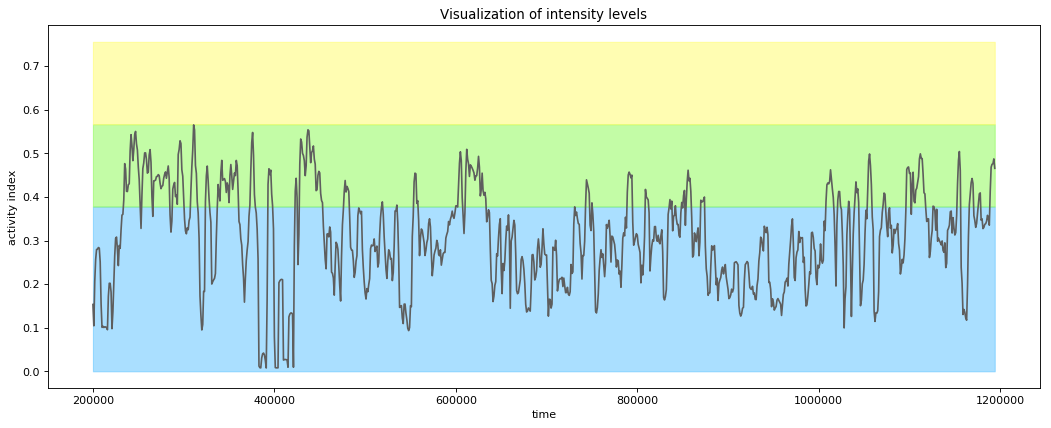

In [39]:
visualize_intensity_levels(activity_indices, maximum_activity.activity_index[maximum_activity.shape[0]-1])